In [1]:
# the class to hande histograms and some helper functions
import copy
import math

def safediv(a,b):
    if float(b) != 0.:
        return a/b
    else:
        return 0.

def get_histo_from_file(fname, hname, htype, nrebin=1):
    content = open(fname).read()
    found = False
    xmin = []
    xmax = []
    y = []
    yerr = []
    
    for l in content.split('\n'):
        if l.startswith("<histogram>") and hname in l and \
        ('TYPE@%s|' % htype in l or 'TYPE@%s"' % htype in l):
            found = True
            continue
        if found and l.startswith("<\\histogram>"):
            break
        if found:
            values = [float(v) for v in l.split()]
            xmin.append(values[0])
            xmax.append(values[1])
            y.append(values[2])
            yerr.append(values[3])
    if not found:
        raise Exception('get_histo_from_file, not found')
    return Histogram(xmin, xmax, y, yerr).rebin(nrebin)


def get_histo_from_datfile(fname, nevents=1., nrebin=1):
    content = open(fname).read()
    xmin = []
    xmax = []
    y = []
    yerr = []
    
    for l in content.split('\n'):
        if not(l): continue
        values = [float(v) for v in l.split()]
        xmin.append(values[0])
        xmax.append(values[1])
        y.append(values[2]/nevents)
        if values[3] != 0:
            yerr.append(values[2]/math.sqrt(values[3])/nevents)
        else:
            yerr.append(0)

    return Histogram(xmin, xmax, y, yerr).rebin(nrebin)
            
    
class Histogram(dict):
    def __init__(self, xmin, xmax, y, yerr):
        if not (len(xmin)==len(xmax)==len(y)==len(yerr)):
            raise Exception('Init, Invalid size')
                
        self['xmin'] = xmin
        self['xmax'] = xmax
        self['x'] = [(x1+x2)/2 for x1,x2 in zip(xmin,xmax)]
        self['y'] = y
        self['yerr'] = yerr
        self['nbins'] = len(xmin)
    
    def __add__(self, other):
        if not (len(self['y']) == len(other['y'])):
            raise Exception('add, Invalid size')
        if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
            raise Exception('add, Invalid x')
        return Histogram(self['xmin'], self['xmax'],
                        [y1+y2 for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt(y1**2+y2**2) for y1,y2 in zip(self['yerr'], other['yerr'])])
    
    def __mul__(self, other):
        if type(other) == float or type(other) == int:
            return Histogram(self['xmin'], self['xmax'],
                    [y1*other for y1 in self['y']],
                        [y1*other for y1 in self['yerr']])
        else:
            raise Exception('mul, not implemented')
            
            
    def __truediv__(self, other):
        if type(other) == float or type(other) == int:
            return Histogram(self['xmin'], self['xmax'],
                    [y1/other for y1 in self['y']],
                        [y1/other for y1 in self['yerr']])
        elif type(other) == Histogram:
            if not (len(self['y']) == len(other['y'])):
                raise Exception('div, Invalid size')
            if not (self['xmin'] == other['xmin'] and self['xmax'] == other['xmax']):
                raise Exception('div, Invalid x')
            return Histogram(self['xmin'], self['xmax'],
                        [safediv(y1,y2) for y1,y2 in zip(self['y'], other['y'])],
                        [math.sqrt(safediv(e1,y2)**2+(safediv(y1,y2**2)*e2)**2) for y1,y2,e1,e2 in zip(self['y'], other['y'], self['yerr'], other['yerr'])])
            
        else:
            raise Exception('div, not implemented')
            
    
    def rebin(self, nbins):
        if (self['nbins']//nbins)*nbins != self['nbins']:
            print('cannot rebin')
            return self
        if nbins == 1:
            return self
        xmin = []
        xmax = []
        y = []
        yerr = []
        for i in range(self['nbins']//nbins):
            i0 = i * nbins
            i1 = (i+1) * nbins  - 1
            xmin.append(self['xmin'][i0])
            xmax.append(self['xmax'][i1])
            y.append(sum(self['y'][i0:i1+1]))
            yerr.append(math.sqrt(sum([err**2 for err in self['yerr'][i0:i1+1]])))
        
        return Histogram(xmin,xmax,y,yerr)
                
            
        

        

<ipython-input-17-6cc38e998a78>:157: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(min([v for v in h_tota['y'] if v !=0])/20, max(h_tota['y'])*2)


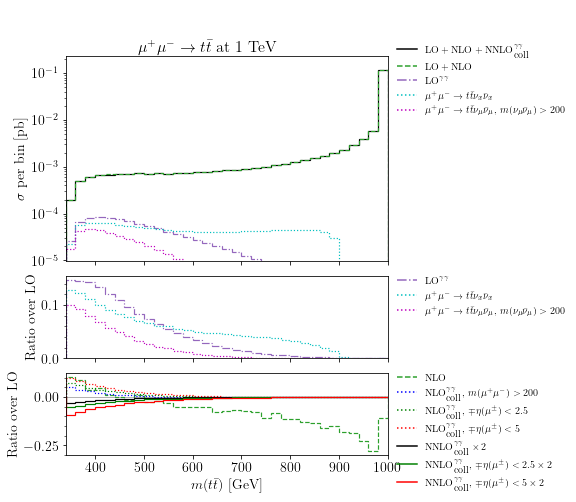

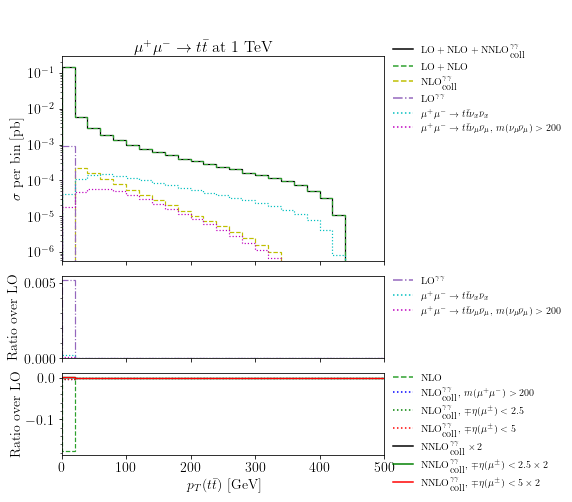

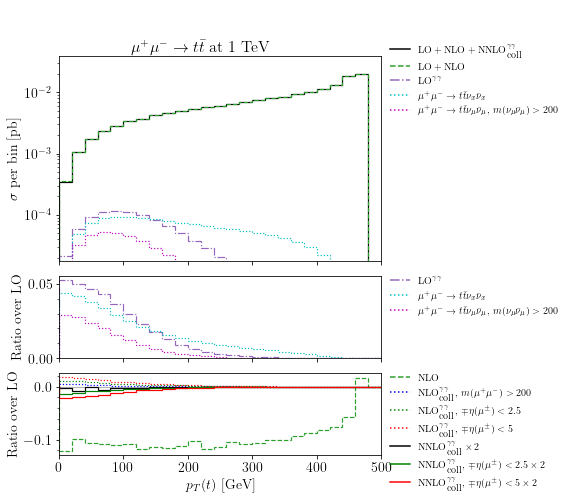

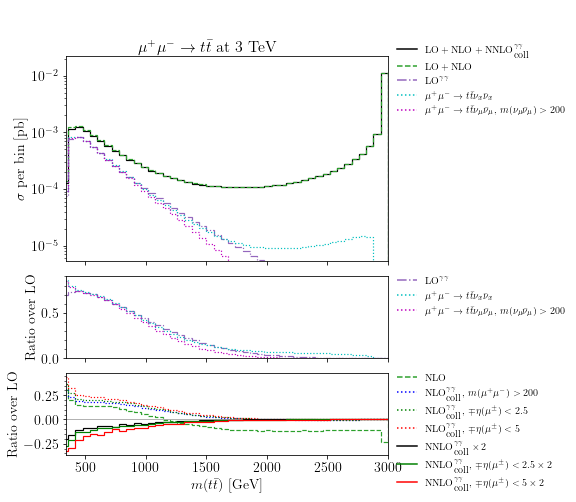

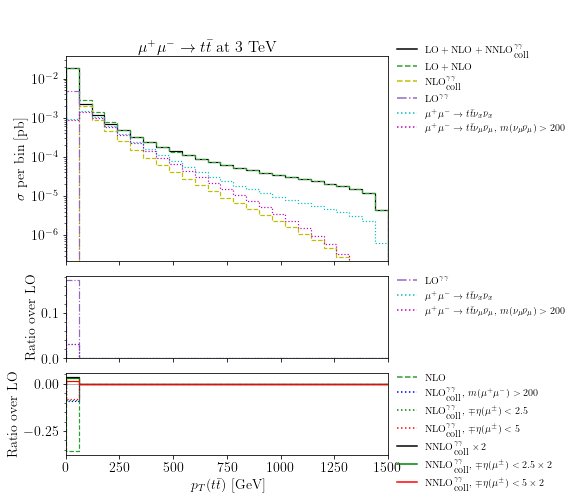

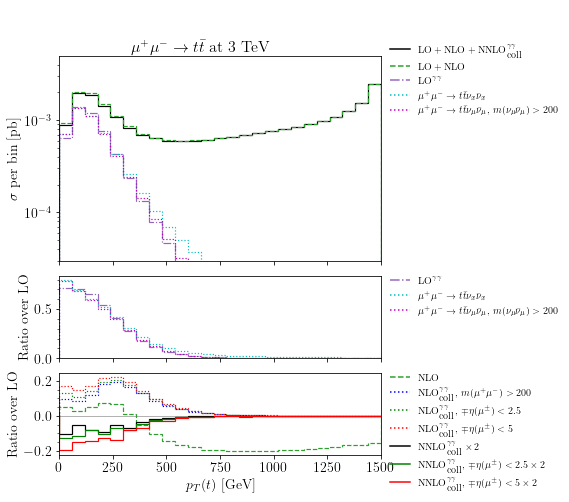

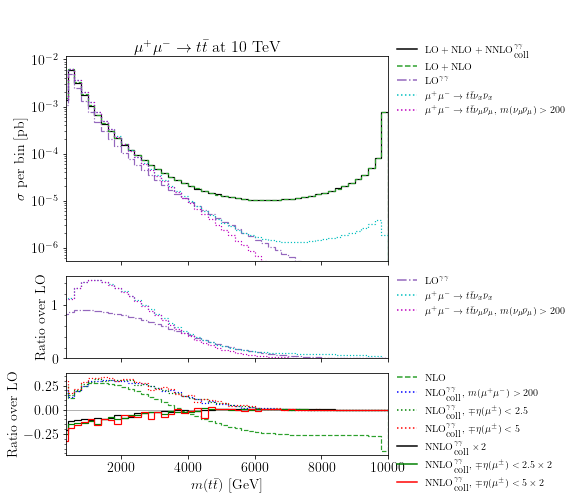

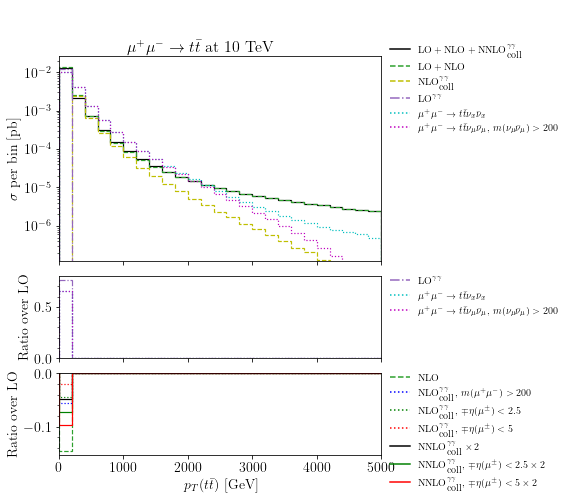

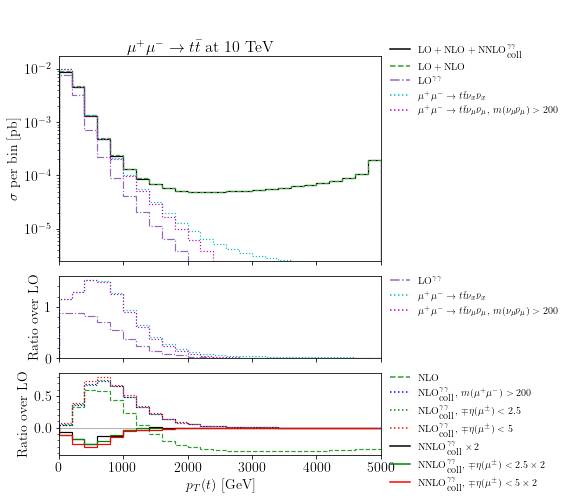

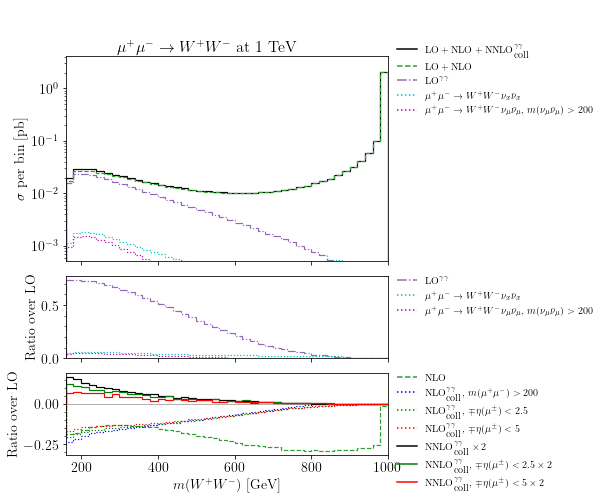

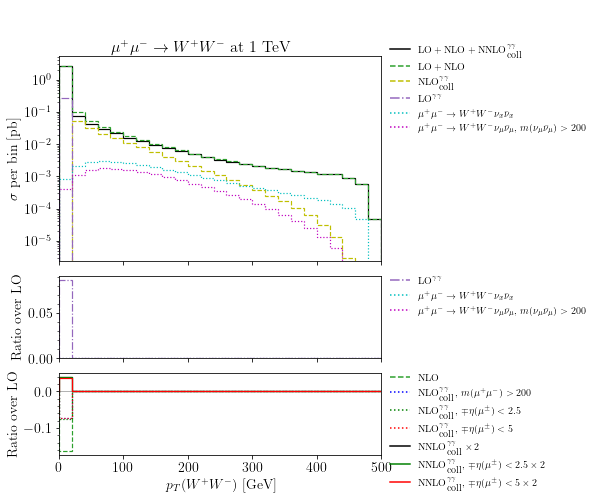

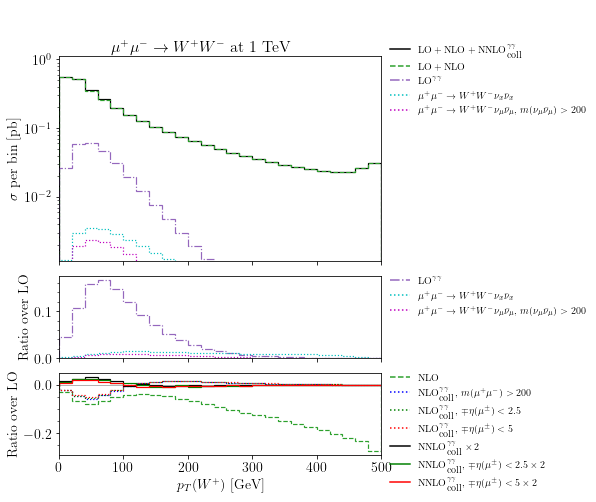

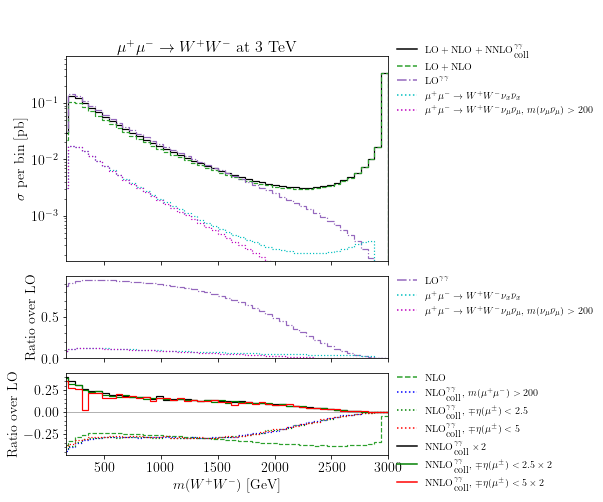

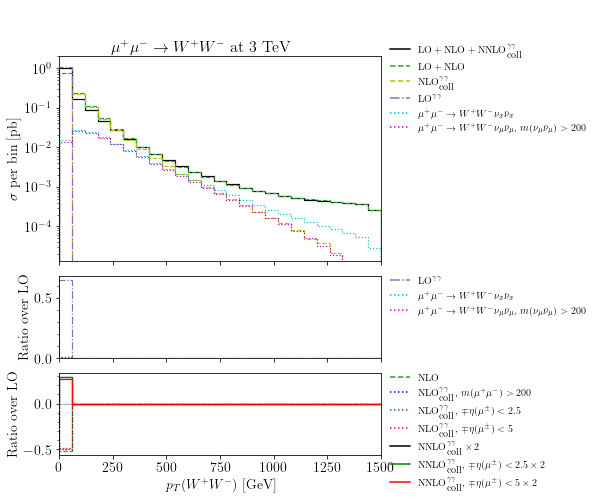

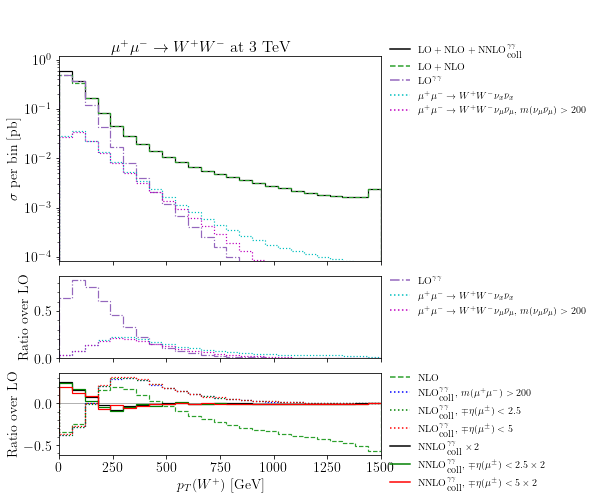

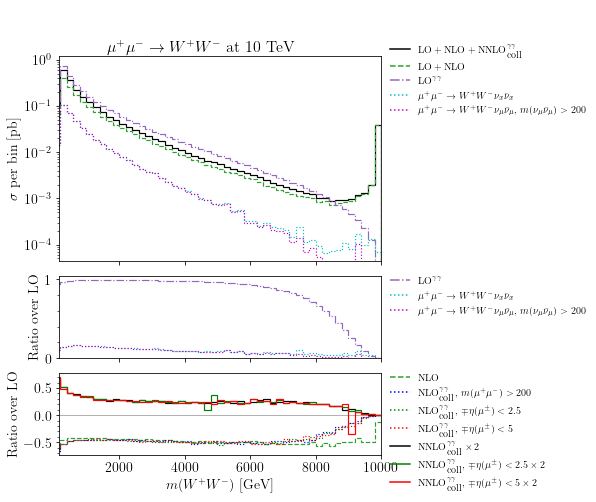

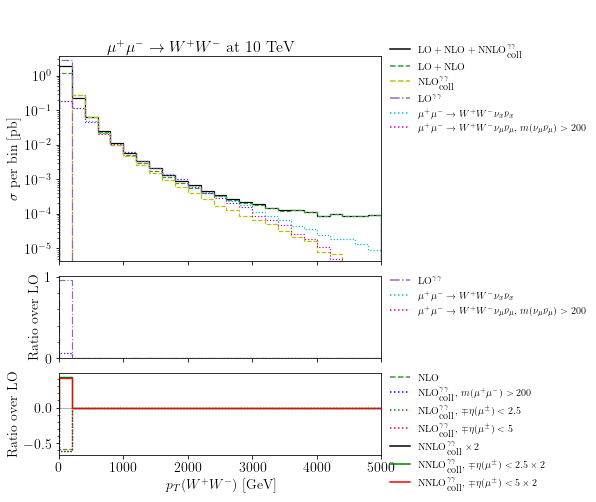

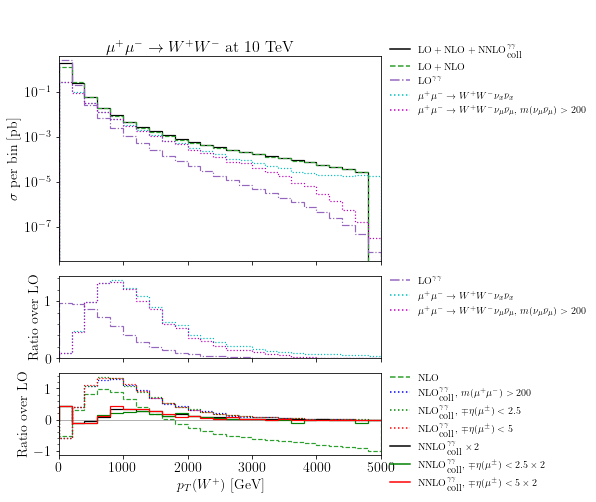

In [17]:
# observables and histograms
import os 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
lw = 1.2
allcolors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values()) + list(mcolors.XKCD_COLORS.values())
allcolors[1] = 'black'
allcolors[0] = 'blue'
allcolors[3] = 'red'
import matplotlib.font_manager as font_manager
import matplotlib.backends.backend_pdf as backend_pdf
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
 
import matplotlib as mpl
#mpl.rcParams.update({"mathtext.fontset": "dejavuserif"})
mpl.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 14})
mpl.rcParams.update({'lines.markersize': 8})
#mpl.rcParams.update({'lines.linewidth': 0.5})
markers_glob = ['o', 'v', 's', '<', '>', 's', 'p', '*', 'h', 'p', 'x', 'X', 'd']
font_legend = font_manager.FontProperties(size=10)

def update_legend(ax, ncol):
    # this is to have the line in the legend, and not the square 
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    for i, h in enumerate(handles):
        ls = h.get_linestyle()
        lc = h.get_edgecolor()
        #mk = markers[i]
        if ls == 'dashed':
            facecolor = 'none'
        else:
            facecolor = lc
        #new_handles.append(mlines.Line2D([], [], c=lc, linestyle=ls, marker = mk, markerfacecolor = facecolor))
        new_handles.append(mlines.Line2D([], [], c=lc, linestyle=ls, markerfacecolor = facecolor))

    ax.legend(handles=new_handles, labels=labels, prop=font_legend, frameon = False, ncol=ncol, 
              loc='upper left', bbox_to_anchor=(1, 1.1))



energies = [1,3,10]
observables = ['mtt', 'pttt', 'pttop']
processes = ['tt', 'ww']

xlabels = {'tt': {'mtt': 'm(t\\bar t)',
                  'pttt': 'p_T(t\\bar t)',
                  'pttop': 'p_T(t)'}, 
           'ww': {'mtt': 'm(W^+W^-)',
                  'pttt': 'p_T(W^+W^-)',
                  'pttop': 'p_T(W^+)'}}
proc_string = {'tt': '$\\mu^+\\mu^- \\to t \\bar t$',
               'ww': '$\\mu^+\\mu^- \\to W^+ W^-$'}
for p in processes:
    for en in energies:
        fname_mg = os.path.join(p, 'run_%dtev_NLO' % en, 'MADatNLO.HwU')
        fname_nnlo = os.path.join(p, 'run_nnlo_%d' % en, 'MADatNLO.HwU')
        fname_wbf = os.path.join(p, 'run_Wfusion_%dtev' % en, 'MADatNLO.HwU')
        fname_nlo_ycut25 = os.path.join(p, 'run_nlo_%d_nomcut_ymin-2.5' % en, 'MADatNLO.HwU')
        fname_nlo_ycut5 = os.path.join(p, 'run_nlo_%d_nomcut_ymin-5.0' % en, 'MADatNLO.HwU')
        fname_nnlo_ycut25 = os.path.join(p, 'run_nnlo_%d_nomcut_nosameflav_ymin-2.5' % en, 'MADatNLO.HwU')
        fname_nnlo_ycut5 = os.path.join(p, 'run_nnlo_%d_nomcut_nosameflav_ymin-5.0' % en, 'MADatNLO.HwU')
        for o in observables:
            try:
                # mg histograms
                h_lo_mg = get_histo_from_file(fname_mg, o, 'LO')
                h_loaa_mg = get_histo_from_file(fname_mg, o, 'LOAA')
                h_nlo_mg = get_histo_from_file(fname_mg, o, 'NLO')
                h_tot_mg = get_histo_from_file(fname_mg, o, 'TOT')
                # nnlo histograms
                h_lo_nnlo = get_histo_from_file(fname_nnlo, o, 'LO')
                h_nlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NLO')
                h_nnlo_nnlo = get_histo_from_file(fname_nnlo, o, 'NNLO')
                
                h_tota = h_nnlo_nnlo + h_tot_mg
            except FileNotFoundError:
                continue
            
            try:
                # wfusion histograms
                h_w_tot = get_histo_from_file(fname_wbf, o, 'LO')
                h_w_vmcut = get_histo_from_file(fname_wbf, o, 'LOVMC')
                foundww = True
            except FileNotFoundError:
                foundww = False
                
            try:
                # nlo_ycut_histograms histograms
                h_nlo_ycut25 = get_histo_from_file(fname_nlo_ycut25, o, 'NLO')
                h_nlo_ycut5 = get_histo_from_file(fname_nlo_ycut5, o, 'NLO')
                foundnloycut = True
            except FileNotFoundError:
                foundnloycut = False
                
            try:
                # nnlo_ycut_histograms histograms
                h_nnlo_ycut25 = get_histo_from_file(fname_nnlo_ycut25, o, 'NNLO')
                h_nnlo_ycut5 = get_histo_from_file(fname_nnlo_ycut5, o, 'NNLO')
                foundnnloycut = True
            except FileNotFoundError:
                foundnnloycut = False
            
            # now the figure
            fig, axes = plt.subplots(nrows = 3, ncols= 1, sharex = True, 
                                     gridspec_kw={'height_ratios': [2.5,1,1]})
            fig.set_size_inches(7*0.75,7)
            fig.suptitle("\n\n" + "    " + proc_string[p] + ' at %d TeV' % en, fontsize=16, y=1.015 ) 
            
            for ax in axes:
                pos = ax.get_position()
                ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
                ax.yaxis.set_minor_locator(AutoMinorLocator())
            
            #main frame, show absolute xsec
            ax = axes[0]
            ax.set_ylabel("$\sigma$ per bin [pb]")
            ax.set_yscale('log')
            if o == 'mtt':
                obsrange = (0.,en*1000.)
            elif o in ['pttt', 'pttop']:
                obsrange = (0.,en*1000.)
                
            if o == 'mtt' and p == 'tt':
                ax.set_xlim(340,en*1000)
            if o == 'mtt' and p == 'ww':
                ax.set_xlim(160,en*1000)
            if o in ['pttt', 'pttop']:
                ax.set_xlim(0,en*1000/2)
            # total
            ax.hist(x = h_tota['x'], weights = h_tota['y'], histtype= 'step', bins = h_tota['nbins'], 
                   label = '$\\textrm{LO}+\\textrm{NLO}+\\textrm{NNLO}^{\\gamma\\gamma}_\\textrm{coll}$',
                   linewidth=lw, color=allcolors[1], range=obsrange)
            
            ax.hist(x = h_tot_mg['x'], weights = h_tot_mg['y'], histtype= 'step', bins = h_tot_mg['nbins'], 
                   label = '$\\textrm{LO}+\\textrm{NLO}$',
                   linewidth=lw, color=allcolors[2], linestyle='dashed', range=obsrange)
            
            if o == 'pttt':
                ax.hist(x = h_nlo_nnlo['x'], weights = h_nlo_nnlo['y'], histtype= 'step', bins = h_nlo_nnlo['nbins'], 
                   label = '$\\textrm{NLO}^{\\gamma\\gamma}_\\textrm{coll}$',
                   linewidth=lw, color=allcolors[15], linestyle='dashed', range=obsrange)
            
            ax.hist(x = h_loaa_mg['x'], weights = h_loaa_mg['y'], histtype= 'step', bins = h_loaa_mg['nbins'], 
                   label = '$\\textrm{LO}^{\\gamma\\gamma}$',
                   linewidth=lw, color=allcolors[4], linestyle='-.', range=obsrange)
            
            if foundww:
                ax.hist(x = h_w_tot['x'], weights = h_w_tot['y'], histtype= 'step', bins = h_w_tot['nbins'], 
                   linewidth=lw, color=allcolors[13], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_x \\bar \\nu_x$", range=obsrange)
            
                ax.hist(x = h_w_vmcut['x'], weights = h_w_vmcut['y'], histtype= 'step', bins = h_w_vmcut['nbins'], 
                   linewidth=lw, color=allcolors[14], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_\\mu \\bar \\nu_\\mu$, $m(\\nu_\mu \\bar \\nu_\\mu)>200$", range=obsrange)            
            
            ax.set_ylim(min([v for v in h_tota['y'] if v !=0])/20, max(h_tota['y'])*2)
            update_legend(ax, ncol=1)

            # inset, lo gamma gamma / lo total
            ax=axes[1]
            ax.set_ylabel("$\\textrm{LO}^{\\gamma\\gamma}/\\textrm{LO}$")
            ax.set_ylabel("Ratio over LO")
            
            h_loratio = h_loaa_mg / h_lo_mg
            ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[4], linestyle='-.',
                   label="$\\textrm{LO}^{\\gamma\\gamma}$", range=obsrange)
            
            if foundww:
                h_loratio = h_w_tot / h_lo_mg
                ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[13], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_x \\bar \\nu_x$", range=obsrange)
            
                h_loratio = h_w_vmcut / h_lo_mg
                ax.hist(x = h_loratio['x'], weights = h_loratio['y'], histtype= 'step', bins = h_loratio['nbins'], 
                   linewidth=lw, color=allcolors[14], linestyle='dotted',
                   label= proc_string[p]+"$\\nu_\\mu \\bar \\nu_\\mu$, $m(\\nu_\mu \\bar \\nu_\\mu)>200$", range=obsrange)
            update_legend(ax, ncol=1)
            
            ax=axes[2]
            # second inset
            ax.set_ylabel("Ratio over LO")
            ax.hist(x = h_lo_mg['x'], weights = [0]*h_lo_mg['nbins'], histtype= 'step', bins = h_lo_mg['nbins'], 
                   linewidth=lw/2, color='gray', linestyle='solid', range=obsrange)        
    
            h_kfac = h_nlo_mg / h_lo_mg
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[2], linestyle='dashed', 
                    label = '$\\textrm{NLO}$', range=obsrange)
            
            h_kfac = h_nlo_nnlo / h_lo_mg
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[10], linestyle='dotted', 
                    label = '$\\textrm{NLO}^{\\gamma\\gamma}_\\textrm{coll}, \, m(\\mu^+\\mu^-)>200$', range=obsrange)
            
            if foundnloycut:
                h_kfac = h_nlo_ycut25 / h_lo_mg
                ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[11], linestyle='dotted', 
                    label = '$\\textrm{NLO}^{\\gamma\\gamma}_\\textrm{coll}, \, \\mp\\eta(\\mu^\\pm) < 2.5$', range=obsrange)
                h_kfac = h_nlo_ycut5 / h_lo_mg
                ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[12], linestyle='dotted', 
                    label = '$\\textrm{NLO}^{\\gamma\\gamma}_\\textrm{coll}, \, \\mp\\eta(\\mu^\\pm) < 5$', range=obsrange)
            
            nnlo_rescale = 2
            h_kfac = h_nnlo_nnlo / h_lo_mg * nnlo_rescale
            ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[1], linestyle='solid', 
                    label = '$\\textrm{NNLO}^{\\gamma\\gamma}_\\textrm{coll} \\times %d$' % nnlo_rescale, range=obsrange)
            
            if foundnnloycut:
                h_kfac = h_nnlo_ycut25 / h_lo_mg * nnlo_rescale
                ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[11], 
                    label = '$\\textrm{NNLO}^{\\gamma\\gamma}_\\textrm{coll}, \, \\mp\\eta(\\mu^\\pm) < 2.5 \\times %d $' % nnlo_rescale, range=obsrange)
                h_kfac = h_nnlo_ycut5 / h_lo_mg * nnlo_rescale
                ax.hist(x = h_kfac['x'], weights = h_kfac['y'], histtype= 'step', bins = h_kfac['nbins'], 
                   linewidth=lw, color=allcolors[12], 
                    label = '$\\textrm{NNLO}^{\\gamma\\gamma}_\\textrm{coll}, \, \\mp\\eta(\\mu^\\pm) < 5 \\times %d $' % nnlo_rescale, range=obsrange)
            
            update_legend(ax, ncol=1)
            
            ax.set_xlabel('$%s$ [GeV]' % xlabels[p][o])
            
            plt.savefig('%s_%s_%dtev.pdf' % (o,p,en), bbox_inches = 'tight')
            
 
    

25 [0.0, 400.0, 800.0, 1200.0, 1600.0, 2000.0, 2400.0, 2800.0, 3200.0, 3600.0, 4000.0, 4400.0, 4800.0, 5200.0, 5600.0, 6000.0, 6400.0, 6800.0, 7200.0, 7600.0, 8000.0, 8400.0, 8800.0, 9200.0, 9600.0]


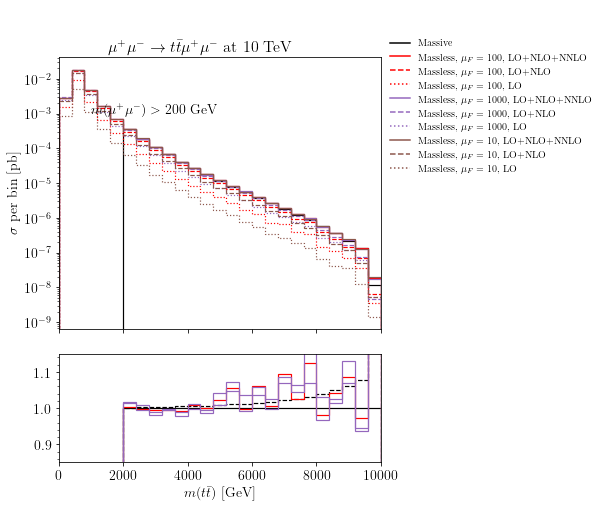

In [14]:
# plots for the technical paper

# mtt, 3tev, mmumu > 200

for en in [10]:

    fname_mg = os.path.join('tt', 'ttbar_massive_madevent', 'histo_mtt_%dtev_fixgenps_mtt2000.dat' % en)
    #fname_mg_check = os.path.join('tt', 'ttbar_massive_madevent', 'histo_mtt_%dtev.dat' % en)

    fname_nnlo1000 = os.path.join('tt', 'run_%dtev_comparemassive_mufix1000' % en, 'MADatNLO.HwU')
    fname_nnlo100 = os.path.join('tt', 'run_%dtev_comparemassive_mufix100' % en, 'MADatNLO.HwU')
    fname_nnlo10 = os.path.join('tt', 'run_%dtev_comparemassive_mufix10' % en, 'MADatNLO.HwU')

    nrebin = 2

    h_mg = get_histo_from_datfile(fname_mg, 1e6, nrebin)
    #h_mg_check = get_histo_from_datfile(fname_mg_check, 1e6, nrebin)

    h_lo_nnlo100 = get_histo_from_file(fname_nnlo100, 'mtt', 'LO', nrebin)
    h_nlo_nnlo100 = get_histo_from_file(fname_nnlo100, 'mtt', 'NLO', nrebin)
    h_nnlo_nnlo100 = get_histo_from_file(fname_nnlo100, 'mtt', 'NNLO', nrebin)
    h_lonlo_nnlo100 = h_lo_nnlo100 + h_nlo_nnlo100
    h_tota_nnlo100 = h_lonlo_nnlo100 + h_nnlo_nnlo100

    h_lo_nnlo1000 = get_histo_from_file(fname_nnlo1000, 'mtt', 'LO', nrebin)
    h_nlo_nnlo1000 = get_histo_from_file(fname_nnlo1000, 'mtt', 'NLO', nrebin)
    h_nnlo_nnlo1000 = get_histo_from_file(fname_nnlo1000, 'mtt', 'NNLO', nrebin)
    h_lonlo_nnlo1000 = h_lo_nnlo1000 + h_nlo_nnlo1000
    h_tota_nnlo1000 = h_lonlo_nnlo1000 + h_nnlo_nnlo1000

    h_lo_nnlo10 = get_histo_from_file(fname_nnlo10, 'mtt', 'LO', nrebin)
    h_nlo_nnlo10 = get_histo_from_file(fname_nnlo10, 'mtt', 'NLO', nrebin)
    h_nnlo_nnlo10 = get_histo_from_file(fname_nnlo10, 'mtt', 'NNLO', nrebin)
    h_lonlo_nnlo10 = h_lo_nnlo10 + h_nlo_nnlo10
    h_tota_nnlo10 = h_lonlo_nnlo10 + h_nnlo_nnlo10

    print(h_lo_nnlo10['nbins'], h_lo_nnlo10['xmin'])

    # now the figure
    fig, axes = plt.subplots(nrows = 2, ncols= 1, sharex = True, 
                                         gridspec_kw={'height_ratios': [2.5,1]})
    fig.set_size_inches(7*0.75,7)
    fig.suptitle("\n\n" + "    " + "$\\mu^+ \\mu^- \\to t \\bar t \\mu^+ \\mu^- $"+ ' at %d TeV' % en, fontsize=16, y=1.03) 

    for ax in axes:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0, pos.width*1.1, pos.height*1.1])
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xlim(0,en*1000)

    ax = axes[0]

    ax.hist(x = h_mg['x'], weights = h_mg['y'], histtype= 'step', bins = h_mg['nbins'], 
                       label = 'Massive',
                       linewidth=lw, color=allcolors[1], range=(0,en*1000))

    #ax.hist(x = h_mg_check['x'], weights = h_mg_check['y'], histtype= 'step', bins = h_mg_check['nbins'], 
    #                   label = 'Massive, beforefix',
    #                   linewidth=lw, color=allcolors[2], range=(0,en*1000))


    ax.hist(x = h_tota_nnlo100['x'], weights = h_tota_nnlo100['y'], histtype= 'step', bins = h_tota_nnlo100['nbins'], 
                       label = 'Massless, $\mu_F=100$, LO+NLO+NNLO',
                       linewidth=lw, color=allcolors[3], range=(0,en*1000))

    ax.hist(x = h_lonlo_nnlo100['x'], weights = h_lonlo_nnlo100['y'], histtype= 'step', bins = h_lonlo_nnlo100['nbins'], 
                       label = 'Massless, $\mu_F=100$, LO+NLO',
                       linewidth=lw, color=allcolors[3], linestyle = 'dashed', range=(0,en*1000))

    ax.hist(x = h_lo_nnlo100['x'], weights = h_lo_nnlo100['y'], histtype= 'step', bins = h_lo_nnlo100['nbins'], 
                       label = 'Massless, $\mu_F=100$, LO',
                       linewidth=lw, color=allcolors[3], linestyle = 'dotted', range=(0,en*1000))


    ax.hist(x = h_tota_nnlo1000['x'], weights = h_tota_nnlo1000['y'], histtype= 'step', bins = h_tota_nnlo1000['nbins'], 
                       label = 'Massless, $\mu_F=1000$, LO+NLO+NNLO',
                       linewidth=lw, color=allcolors[4], range=(0,en*1000))

    ax.hist(x = h_lonlo_nnlo1000['x'], weights = h_lonlo_nnlo1000['y'], histtype= 'step', bins = h_lonlo_nnlo1000['nbins'], 
                       label = 'Massless, $\mu_F=1000$, LO+NLO',
                       linewidth=lw, color=allcolors[4], linestyle = 'dashed', range=(0,en*1000))

    ax.hist(x = h_lo_nnlo1000['x'], weights = h_lo_nnlo1000['y'], histtype= 'step', bins = h_lo_nnlo1000['nbins'], 
                       label = 'Massless, $\mu_F=1000$, LO',
                       linewidth=lw, color=allcolors[4], linestyle = 'dotted', range=(0,en*1000))


    ax.hist(x = h_tota_nnlo10['x'], weights = h_tota_nnlo10['y'], histtype= 'step', bins = h_tota_nnlo10['nbins'], 
                       label = 'Massless, $\mu_F=10$, LO+NLO+NNLO',
                       linewidth=lw, color=allcolors[5], range=(0,en*1000))

    ax.hist(x = h_lonlo_nnlo10['x'], weights = h_lonlo_nnlo10['y'], histtype= 'step', bins = h_lonlo_nnlo10['nbins'], 
                       label = 'Massless, $\mu_F=10$, LO+NLO',
                       linewidth=lw, color=allcolors[5], linestyle = 'dashed', range=(0,en*1000))

    ax.hist(x = h_lo_nnlo10['x'], weights = h_lo_nnlo10['y'], histtype= 'step', bins = h_lo_nnlo10['nbins'], 
                       label = 'Massless, $\mu_F=10$, LO',
                       linewidth=lw, color=allcolors[5], linestyle = 'dotted', range=(0,en*1000))

    ax.set_ylabel("$\sigma$ per bin [pb]")
    ax.set_yscale('log')

    ax.text( 1000, 1e-3, '$m(\\mu^+\\mu^-) > 200$ GeV')

    update_legend(ax, ncol=1)


    ax = axes[1]



    ax.hist(x = h_mg['x'], weights = [1 if y !=0 else 0 for y in h_mg['y']], histtype= 'step', bins = h_mg['nbins'], 
                       label = 'Massive',
                       linewidth=lw, color=allcolors[1], range=(0,en*1000))


    ax.hist(x = h_mg['x'], weights = [(y+err)/y if y !=0. else 0 for y,err in zip(h_mg['y'], h_mg['yerr'])], histtype= 'step', bins = h_mg['nbins'], 
                       label = 'Massive',
                       linewidth=lw, color=allcolors[1], linestyle = 'dashed', range=(0,en*1000))

    #h_ratio = h_mg_check/h_mg
    #ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
    #                   linewidth=lw, color=allcolors[2], range=(0,en*1000))

    h_ratio = h_tota_nnlo100/h_mg
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[3], range=(0,en*1000))

    h_ratio = h_tota_nnlo1000/h_mg
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000))

    h_ratio = h_tota_nnlo10/h_mg
    ax.hist(x = h_ratio['x'], weights = h_ratio['y'], histtype= 'step', bins = h_ratio['nbins'], 
                       linewidth=lw, color=allcolors[4], range=(0,en*1000))

    ax.set_ylim(0.85,1.15)
 

    ax.set_xlabel('$m(t\\bar t)$ [GeV]')
    plt.savefig('check_massive_%dtev.pdf'  % en, bbox_inches = 'tight')